In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score as ras
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

In [4]:
data = pd.read_csv('new_data.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


<Axes: xlabel='type', ylabel='count'>

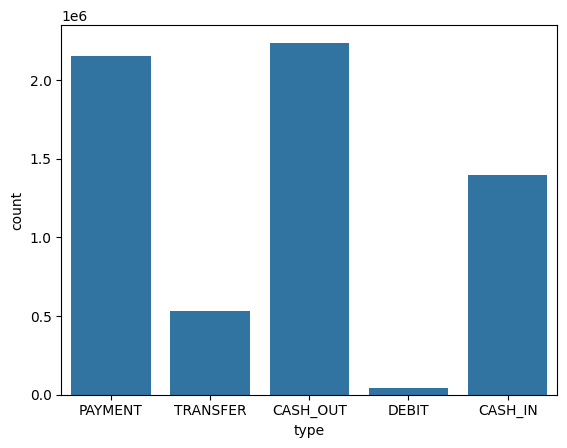

In [7]:
sns.countplot(x='type', data=data)

In [8]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

<Axes: >

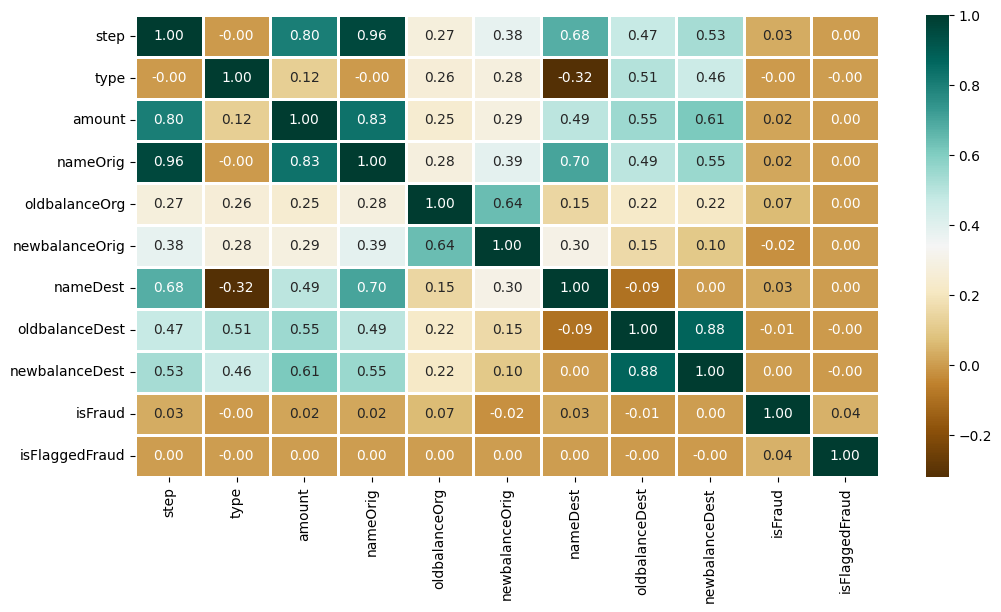

In [9]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.apply(lambda x: pd.factorize(x)[0]).corr(),
			cmap='BrBG',
			fmt='.2f',
			linewidths=2,
			annot=True)

In [10]:
type_new = pd.get_dummies(data['type'], drop_first=True)
data_new = pd.concat([data, type_new], axis=1)
data_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,False,False,True,False
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,False,False,True,False
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,False,False,False,True
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,True,False,False,False
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,False,False,True,False


In [11]:
X = data_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = data_new['isFraud']

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [13]:
models = [LogisticRegression(max_iter=1000), XGBClassifier(),
          RandomForestClassifier(n_estimators=7,
                                 criterion='entropy', 
                                 random_state=7)]

for i in range(len(models)):
    models[i].fit(X_train, y_train)
    print(f'{models[i]} : ')
    
    train_preds = models[i].predict_proba(X_train)[:, 1]
    print('Training Accuracy : ', ras(y_train, train_preds))
    
    y_preds = models[i].predict_proba(X_test)[:, 1]
    print('Validation Accuracy : ', ras(y_test, y_preds))
    print()

LogisticRegression(max_iter=1000) : 
Training Accuracy :  0.989138520586458
Validation Accuracy :  0.9875062993935725

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) : 
Training Accuracy :  0.7078356072170395
Validation Accuracy :  0.7124525368938691

RandomForestClassifier(criterion='

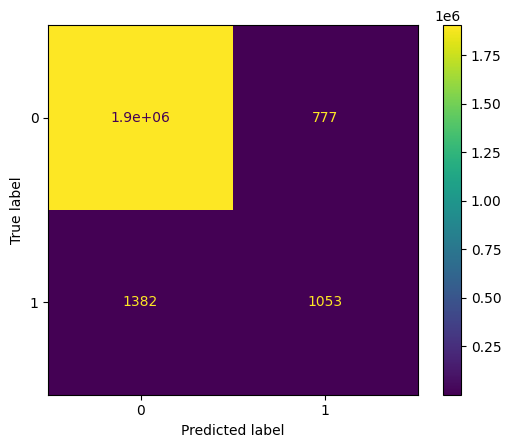

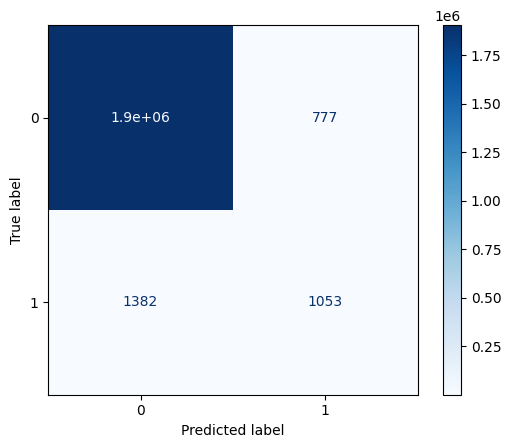

In [14]:
cm = ConfusionMatrixDisplay.from_estimator(models[1], X_test, y_test) 
cm.plot(cmap='Blues') 
plt.show()

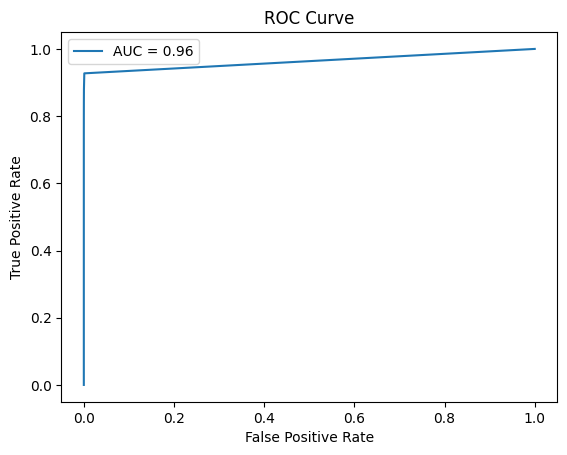

In [17]:
from sklearn.metrics import roc_auc_score
fpr, tpr, _ = roc_curve(y_test, y_preds)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_preds):.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()